# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет **определить регион**, где добыча принесёт наибольшую прибыль. Проанализируйте **возможную прибыль и риски** техникой *Bootstrap.*

**Шаги для выбора локации:**
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**
- Для обучения модели подходит только **линейная регрессия** (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на **разработку скважин** в регионе — 10 млрд рублей.
- При нынешних ценах **доход с каждой единицы продукта** составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых **вероятность убытков** меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**План работы:**
1. [Загрузка и знакомство с исходными данными.](#section_1)
2. [Обучение и проверка модели.](#section_2)
3. [Подготовка к расчёту прибыли.](#section_3)
4. [Функция для расчёта прибыли.](#section_4)
5. [Расчёт прибыли и рисков.](#section_5)
6. [Итоговый вывод.](#section_5)
___

<a id='section_1'></a>
## 1. Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt
from scipy.stats import  percentileofscore

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### 1.1. Чтение и знакомство с данными

In [2]:
try:
    try:
        # домашняя версия
        df1 = pd.read_csv('datasets\geo_data_0.csv')
        df2 = pd.read_csv('datasets\geo_data_1.csv')
        df3 = pd.read_csv('datasets\geo_data_2.csv')
    except:
        # сетевая версия
        df1 = pd.read_csv('/datasets/geo_data_0.csv')
        df2 = pd.read_csv('/datasets/geo_data_1.csv')
        df3 = pd.read_csv('/datasets/geo_data_2.csv')
    
    # вывод прочитанных данных
    display(df1.head())
    display(df2.head())
    display(df3.head())
    
except:
    print('Не удалось прочесть файл. Возможно, был указан неверный путь.')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Описание данных**

Признаки: `f0`, `f1`, `f2` — _три характеристики качества нефти скважины_

Целевой признак: `product` — _объём запасов в скважине (тыс. баррелей)_

Вспомогательная колонка: `id` — _уникальный идентификатор скважины_

Исходные данные: `geo_data_0`, `geo_data_1`, `geo_data_2` сохранены в: `df1` (Регион №1), `df2`(Регион №2), `df3` (Регион №3), соответственно.

### 1.2. Контроль пропусков, дубликатов и типов данных

In [3]:
for df, reg in zip([df1, df2, df3], ['РЕГИОН №1','РЕГИОН №2','РЕГИОН №3']):
    print(f'\n------------< {reg} >------------')
    print(df.info())
    print('Явные дубликаты:', df.duplicated().sum())
    print('Неявные дубликаты:', df['id'].duplicated().sum())    


------------< РЕГИОН №1 >------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Явные дубликаты: 0
Неявные дубликаты: 10

------------< РЕГИОН №2 >------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Явн

**Вывод:** Пропуски и явные дубликаты объектов - отсутствую. Встречается дублирование скважин (колонка `id`), но кол-во повторов невелико: 4-10 из 10 тыс. объектов. Возможно, это повторные измерения. Эти объекты можно оставить, т.к. если их присутствие и вносит ошибку, то небольшую, а модель будет их рассматривать как индивидуальные объекты.
Необходимости в кодировании и маштабировании данных нет.
___

<a id='section_2'></a>
## 2. Обучение и проверка модели

- 2.1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
- 2.2. Обучите модель и сделайте предсказания на валидационной выборке.
- 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.
- 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
- 2.5. Проанализируйте результаты.

In [4]:
targets = []
predictions = []

for df, reg in zip([df1, df2, df3], ['РЕГИОН №1','РЕГИОН №2','РЕГИОН №3']):
    
    # выделение признаков
    main_features = df[['f0', 'f1', 'f2']]
    main_target = df['product']
    
    # разделение данных на обучающую и валидационные выборки
    features_train, features_valid, target_train, target_valid = train_test_split(main_features,
                                                                                  main_target,
                                                                                  train_size=0.75,
                                                                                  random_state=1234)
    
    # обучение модели и предсказание объёмов сырья
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    rmse = sqrt(mean_squared_error(target_valid, prediction_valid))
    
    # сохранение целевых признаков и предсказаний на валидационной выборке.
    targets.append(list(target_valid))
    predictions.append(prediction_valid)
    
    # вывод результатов
    print(f'\n-----------------------------< {reg} >-----------------------------')
    print('Средний запас предсказанного сырья для одной точки: {:.1f} тыс. баррелей,'.format(prediction_valid.mean()))
    print('                         с абсолютной погрешностью ±{:.2f} тыс. баррелей,'.format(rmse))
    print('                                 или относительной ±{:.1f}%'.format(rmse / prediction_valid.mean() * 100))

# сохранение цел. признаков по регионам
target_valid_1 = pd.Series(targets[0])
target_valid_2 = pd.Series(targets[1])
target_valid_3 = pd.Series(targets[2])

# сохранение предсказаний по регионам
prediction_valid_1 = pd.Series(predictions[0])
prediction_valid_2 = pd.Series(predictions[1])
prediction_valid_3 = pd.Series(predictions[2])


-----------------------------< РЕГИОН №1 >-----------------------------
Средний запас предсказанного сырья для одной точки: 92.4 тыс. баррелей,
                         с абсолютной погрешностью ±37.56 тыс. баррелей,
                                 или относительной ±40.6%

-----------------------------< РЕГИОН №2 >-----------------------------
Средний запас предсказанного сырья для одной точки: 68.8 тыс. баррелей,
                         с абсолютной погрешностью ±0.89 тыс. баррелей,
                                 или относительной ±1.3%

-----------------------------< РЕГИОН №3 >-----------------------------
Средний запас предсказанного сырья для одной точки: 94.9 тыс. баррелей,
                         с абсолютной погрешностью ±40.10 тыс. баррелей,
                                 или относительной ±42.3%


**Вывод:** Из исходных данных, значения колонки `id` не будут приниматься в качестве признаков - т.к. они представляют из себя _уникальные имена_ скважин. Каждый датафрейм обрабатывается индивидуально, последовательно друг за другом. Исходная выборка разделена на **обучающую** (75%) и **валидационную** (25%), на которой спрогнозирован объём сырья и расчитано отклонение (_RMSE_). Результаты сохранены. Средний запас сырья и погрешность предсказаний выведены на экран.

**Регион №1** и **№3** - _средние запасы_ скважины одинаково высокий (92 и 94 тыс.бар., соответственно), но предсказание имеет большую _погрешность_ (±40%), в отличии от **региона №2** в котором _средние запасы_ скважины значительно меньше, но их объём получилось предсказать весьма точно: ±1.3% (0.89 тыс.бар.)
___

<a id='section_3'></a>
## 3. Подготовка к расчёту прибыли

- 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.
- 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
- 3.3. Напишите выводы по этапу подготовки расчёта прибыли.

**Объявленные переменные, их описание и значения:**
- `oil_price` (_cтоимость готовой продукции_)  =  450 000₽ / тыс.барралей.
- `wells_price` (_себестоимость добычи_)  =  10 000 000 000₽ / 200 скважин.
- `wells_count` (_количество скважин_)  = 200 шт.
- `revenue` (_оборот_)  =  стоимость продукции * объём продукции
- `gross_profit` (_выловая прибыль_)  =  оборот - себестоимости
- `operating_cost` (_операционные расходы_): неизвестны, из-за чего не получится рассчитать _чистую прибыль_.

*все денежные значения измеряются в _российских рублях_ (₽)

In [5]:
oil_price = 450000   # доход с тысячи баррелей продукта (значение в рублях)
wells_price = 10**10 # стоимость разработки скважин для одного региона (значение в рублях)
wells_count = 200    # кол-во скважин в пределах одного региона

oil_min_count = wells_price / wells_count / oil_price
print('Достаточный объём сырья для безубыточной разработки новой скважины: {:.2f} тыс.бар.'.format(oil_min_count))

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс.бар.


**Вывод:** Это начальный этап расчёта прибыли, на котором были **введены ключевые величины** для расчёта прибыли. Их значения и формула расчёта были описаны в сооветствующем разделе, выше. Так же высчитан **минимальный объём сырья**, который компенсирует себестоимоть добычи: **111.(1) тыс.бар.**
___

<a id='section_4'></a>
## 4. Функция для расчёта прибыли

- 4.1. Выберите скважины с максимальными значениями предсказаний. 
- 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [6]:
def profit_calculation(prediction, target, oil_price, wells_price, wells_count):
    sorted_prediction = prediction.sort_values(ascending=False)[0:wells_count] # сохранение 200 лучших скважин по объёму сырья
    selected_target = target[sorted_prediction.index] # отбор реальных значений объёма сырья для 200 лучших скважин
    product_sum = sum(selected_target) # суммирования объёма предсказанного сырья
    profit = (product_sum * oil_price - wells_price) / (10**6) # величина прибыли за вычетом затрат на разработку месторождений
    return profit # возвращает значение в млн.₽

___

<a id='section_5'></a>
## 5. Расчёт прибыли и рисков 

- 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков.
- 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.


--------------------------< РЕГИОН №1 >--------------------------
Средняя прибыль региона: 387.5 млн.₽
95% вероятной прибыли находится в интервале: [-164.6; 872.4] млн.₽
Риск убытков: 6.9%

--------------------------< РЕГИОН №2 >--------------------------
Средняя прибыль региона: 419.1 млн.₽
95% вероятной прибыли находится в интервале: [26.0; 803.8] млн.₽
Риск убытков: 1.8%

--------------------------< РЕГИОН №3 >--------------------------
Средняя прибыль региона: 354.7 млн.₽
95% вероятной прибыли находится в интервале: [-172.9; 889.2] млн.₽
Риск убытков: 10.6%


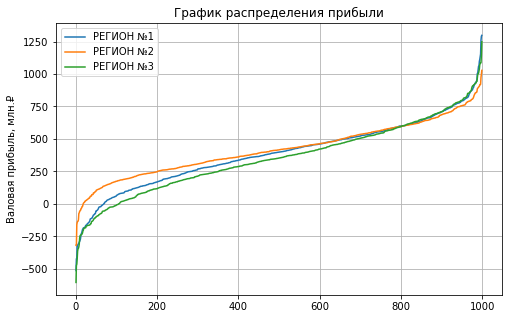

In [7]:
profit_list = []
state = np.random.RandomState(12345)

for prediction, target, reg in zip([prediction_valid_1, prediction_valid_2, prediction_valid_3],
                                   [target_valid_1, target_valid_2, target_valid_3],
                                   ['РЕГИОН №1', 'РЕГИОН №2', 'РЕГИОН №3']):
    
    # примените техники Bootstrap для 1000 выборок
    profit_list = []
    for i in range(1000):
        subsample = prediction.sample(n=500, replace=True, random_state=state) # создание случайной подвыборки на 500 объектов
        gross_profit = profit_calculation(subsample, target, oil_price, wells_price, wells_count) # расчёт валовой прибыли
        profit_list.append(gross_profit) # сохранение результата
    
    # вывод результатов 
    profits = pd.Series(profit_list).sort_values(ignore_index=True)
    print(f'\n--------------------------< {reg} >--------------------------')
    print('Средняя прибыль региона: {:.1f} млн.₽'.format(profits.mean()))
    print('95% вероятной прибыли находится в интервале: [{:.1f}; {:.1f}] млн.₽'.format(profits.quantile(0.025),
                                                                                          profits.quantile(0.975)))
    print('Риск убытков: {:.1f}%'.format(percentileofscore(profits, -0)))
    
    # изображение распределние прибыли
    profits.plot(label=reg, legend=True,
                 figsize=(8, 5), grid=True,
                 ylabel='Валовая прибыль, млн.₽',
                 title='График распределения прибыли')

<a id='section_6'></a>
**ИТОГ:** техникой _Bootstrap_ были перебраны 1000 комбинаций выборок по 500 случайных скважин, из числа которых отбирались 200 лучших (по объёму предсказанных запасов) и на их примере расчитывалась возможная прибыль. Функция расчёта прибыли описана в предыдущем разделе. Из тысячи полученны значений прибыли получилось распределение, которое изображено на графике. Для оценки возможных значений прибыли был взят 95% доверительный интервал.

**Регион №1** и **№3** имеют наибольший диапазон значений прибыли, часть которого лежит в зоне убытков, риск которого: 6.9% и 10.6%, соответственно.
**Регион №2** имеет наибольшую _среднюю прибыль_ **419 млн.₽**, и минимальную долю _риска_: **1.8%**, что соотвествует ключевому условию выбора региона, и определяет его, как единственный регион для добычи с наибольшей прибылью.
___

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
- [x]  Выполнен шаг 4: написана функция расчёта прибыли
- [x]  Выполнен шаг 5: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован